## Merging injury and gamelog data

In [2]:
import numpy as np
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/Users/freedom/anaconda3/lib/python3.6/site-packages/fuzzywuzzy/fuzz.py:35: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# File I/O

In [3]:
injury_file = 'injuries.csv'
injury = pd.read_csv(injury_file)

In [23]:
game_file = 'gamelogs.csv'
games = pd.read_csv(game_file, index_col=0)

In [26]:
print(injury.shape)
injury.head()

(9043, 4)


,Date,DL_length,player_id,dt_date
0,20000323,60,thomj005,2000-03-23
1,20000401,15,alvaw001,2000-04-01
2,20000401,15,osuna002,2000-04-01
3,20000408,15,hamid001,2000-04-08
4,20000408,15,timlm001,2000-04-08


In [27]:
games.head()

,real_index,date,num_game,day,v_team,v_team_game_num,h_team,h_team_game_num,v_team_score,h_team_score,...,h_pl_1_id,h_pl_2_id,h_pl_3_id,h_pl_4_id,h_pl_5_id,h_pl_6_id,h_pl_7_id,h_pl_8_id,h_pl_9_id,intra_league
dt_date,,,,,,,,,,,,,,,,,,,,,
2000-03-29,0,20000329,0,Wed,CHN,1,NYN,1,5,3,...,hendr001,hamid001,alfoe001,piazm001,ventr001,belld001,zeilt001,ordor001,hampm001,1
2000-03-30,1,20000330,0,Thu,NYN,2,CHN,2,5,1,...,youne001,bufod001,sosas001,gracm001,rodrh001,andrs001,husoj001,giraj001,farnk001,1
2000-04-03,2,20000403,0,Mon,KCA,1,TOR,1,4,5,...,stews002,bushh001,mondr002,delgc001,fullb001,batit001,fletd001,cruzj004,gonza001,1
2000-04-03,3,20000403,0,Mon,CHA,1,TEX,1,4,10,...,clayr001,greer001,rodri001,palmr001,mater001,segud001,kaplg001,evant001,alicl001,1
2000-04-03,4,20000403,0,Mon,DET,1,OAK,1,7,4,...,beckr002,tejam001,giamj001,jahaj001,staim001,grieb001,hernr002,chave001,menef001,1


In [28]:
# How big is this games table?
print(games.shape)
#(41292, 96)

(41292, 96)


## Creating a Target column:
When I loop through the game log table, I am going to update a column for "injury" at any game where we know a player on the disabled list played in THAT game and went on the DL soon after.

In [29]:
# Create a column of zeros for 'injury' TARGET column to append to the games df that matches
# the games row length: 43720 rows long
games['injury']  = np.zeros((games.shape[0],), dtype=np.int)

In [30]:
games.index = pd.to_datetime(games.index)

### For the sake of using the function, subset games to just columns needed for finding DL list players: pl_id cols: real_index col and cols 71:95

In [31]:
# Create a small subset of the indexed games dataframe to only include the game date 
# and all the players' ids, cols 71:95
sm_games = pd.concat([games.iloc[:,0], games.iloc[:,71:95]], axis=1)
sm_games.shape

(41292, 25)

### Create a dictionary with real_index as the key and 0 as the values, to update += 1 every time a game row was the last game a DL player played in before his Disabled List placement date:

In [32]:
# This creates (and clears) the injury_update dictionary that will become the TARGET column:
injury_update_dict = games['injury']
injury_update_dict = injury_update_dict.reset_index()
injury_update_dict = injury_update_dict.drop('dt_date',axis=1).to_dict()
sum(injury_update_dict['injury'].values())

0

## Update injury_update_dict:
* Loop through all rows in the Disabled List data, and for every placement (dl_place), 
  * subset the games data to all games 10 days before that DL placement date to save search time. 
  * Loop through all games in the subset, and 
      * if the player_id from the placement is in the game, 
          * save that row index as the index to update. 
          
  * Increase the value of the injury_update_dict whose key is the index to update by + 1
 

### TESTING A LOOP ON SUBSET BEFORE DEFINING A FUNCTION:

In [402]:
# FOR PRACTICE RUNS THROUGH THE FOR LOOPS:
# Subset dataframes to practice on:
sm_games_subset = sm_games.iloc[:5000,:].copy()
sm_inj_subset = injury.iloc[:150,2:].copy()

injury_count = 0
for dl_place in sm_inj_subset.itertuples():
    print(dl_place)
    if dl_place[1] is not np.nan:
        pid = dl_place[1]
        search_end_day = dl_place[2]
        search_start_day = search_end_day-pd.offsets.Day(10)
        subset_games = sm_games_subset[search_start_day:search_end_day]
        for game in subset_games.itertuples():
            if pid in game:
                print('yes')
                print(game.real_index)
                game_index_to_update = game.real_index 
        injury_update_dict['injury'][game_index_to_update] += 1
        injury_count += 1

# Check how many injuries recorded        
print('injury count:', injury_count, 'dict count:',sum(injury_update_dict['injury'].values()))


Pandas(Index=0, player_id='thomj005', dt_date=Timestamp('2000-03-23 00:00:00'))
Pandas(Index=1, player_id='alvaw001', dt_date=Timestamp('2000-04-01 00:00:00'))
Pandas(Index=2, player_id='osuna002', dt_date=Timestamp('2000-04-01 00:00:00'))
Pandas(Index=3, player_id='hamid001', dt_date=Timestamp('2000-04-08 00:00:00'))
yes
0
yes
1
yes
30
yes
44
Pandas(Index=4, player_id='timlm001', dt_date=Timestamp('2000-04-08 00:00:00'))
Pandas(Index=5, player_id='hernc001', dt_date=Timestamp('2000-04-08 00:00:00'))
yes
5
yes
30
yes
44
Pandas(Index=6, player_id='wagnb001', dt_date=Timestamp('2000-06-21 00:00:00'))
yes
951
Pandas(Index=7, player_id='olivd001', dt_date=Timestamp('2000-06-21 00:00:00'))
yes
899
yes
971
Pandas(Index=8, player_id='cabra001', dt_date=Timestamp('2000-07-03 00:00:00'))
yes
1106
yes
1121
yes
1150
yes
1165
Pandas(Index=9, player_id=nan, dt_date=Timestamp('2000-07-07 00:00:00'))
Pandas(Index=10, player_id='ferno001', dt_date=Timestamp('2000-07-07 00:00:00'))
yes
1165
yes
1243
Pa

Pandas(Index=111, player_id=nan, dt_date=Timestamp('2001-04-21 00:00:00'))
Pandas(Index=112, player_id='osuna002', dt_date=Timestamp('2001-04-21 00:00:00'))
Pandas(Index=113, player_id='hillg001', dt_date=Timestamp('2001-04-22 00:00:00'))
yes
2554
yes
2564
yes
2594
yes
2608
yes
2631
yes
2649
yes
2660
Pandas(Index=114, player_id=nan, dt_date=Timestamp('2001-04-22 00:00:00'))
Pandas(Index=115, player_id=nan, dt_date=Timestamp('2001-04-24 00:00:00'))
Pandas(Index=116, player_id='walkk001', dt_date=Timestamp('2001-04-24 00:00:00'))
Pandas(Index=117, player_id=nan, dt_date=Timestamp('2001-04-25 00:00:00'))
Pandas(Index=118, player_id='stepg001', dt_date=Timestamp('2001-04-25 00:00:00'))
Pandas(Index=119, player_id='alvaw001', dt_date=Timestamp('2001-04-25 00:00:00'))
Pandas(Index=120, player_id='wittb001', dt_date=Timestamp('2001-04-25 00:00:00'))
Pandas(Index=121, player_id='leita001', dt_date=Timestamp('2001-04-25 00:00:00'))
yes
2664
Pandas(Index=122, player_id='cresf001', dt_date=Timest

# DEFINE A FUNCTION TO FIND THE LAST GAME PLAYED:
* Make sure to clear out the injury_update_dict between iterations

In [33]:
def find_last_game(player_id, dl_date, games_df, num_days):
    """Function takes in a player_id and disabled list placement
    date and subsets the game logs (with a datetime index) to find the last date they played before
    the disabled list placement"""
    game_index_to_update = 999999
    search_end_day = dl_date
    search_start_day = search_end_day - pd.offsets.Day(num_days)
    subset_games = games_df[search_start_day:search_end_day]
    if subset_games.shape[0] > 0: # IF there are games 20 days before that day
        for game in subset_games.itertuples(): #loop through all games in 20 day period
            if player_id in game:
                game_index_to_update = game.real_index
            else:
                continue
    else: # If there were no games to check, return out of the function
        return game_index_to_update
    return game_index_to_update

## Use `find_last_game()` to create TARGET column:

In [34]:
# make sure target date is datetime
injury.index = pd.to_datetime(injury.index)

In [35]:
# Use sm_games
sm_inj = injury.iloc[:,2:].copy()

injury_count = 0
for dl_place in sm_inj.itertuples():
    if dl_place[1] is not np.nan:
        dl_date = pd.to_datetime(dl_place[2])
        index_to_update = find_last_game(dl_place[1],dl_date,sm_games,400)
        if index_to_update != 999999:
            injury_update_dict['injury'][index_to_update] += 1
            injury_count += 1
        else:
            continue
# Check how many injuries recorded        
print('injury count:', injury_count, 'dict count:',sum(injury_update_dict['injury'].values()))

injury count: 7482 dict count: 7482


### Add the values from the injury update dict back into the games

In [36]:
games['injury'] = games['real_index'].map(injury_update_dict['injury'])

In [37]:
games['injury'].value_counts()

0     36032
1      3649
2      1181
3       294
4       105
5        21
6         9
10        1
Name: injury, dtype: int64

In [38]:
games_prep = games.copy()

In [39]:
games.to_csv('full_games_with_injuries_no_dummies.csv',index=True)

### One Hot Encode Categorical Columns before saving to CSV

In [40]:
games_prep.columns

Index(['real_index', 'date', 'num_game', 'day', 'v_team', 'v_team_game_num',
       'h_team', 'h_team_game_num', 'v_team_score', 'h_team_score',
       'game_length_outs', 'day_night', 'park_id', 'attendance',
       'time_game_min', 'v_at_bats', 'v_hits', 'v_doubles', 'v_triples',
       'v_homeruns', 'v_RBI', 'v_sac_hits', 'v_sac_files', 'v_hit_pitch',
       'v_walks', 'v_int_walks', 'v_strikeouts', 'v_stol_base',
       'v_caught_steal', 'v_grnd_dbl_plays', 'v_awd_fst_catch_intf',
       'v_left_on_base', 'v_pitchers', 'v_ind_earn_runs', 'v_team_earn_runs',
       'v_wild_pitch', 'v_balks', 'v_putouts', 'v_assists', 'v_errors',
       'v_pass_balls', 'v_dbl_plays', 'v_trp_plays', 'h_at_bats', 'h_hits',
       'h_doubles', 'h_triples', 'h_homeruns', 'h_RBI', 'h_sac_hits',
       'h_sac_files', 'h_hit_pitch', 'h_walks', 'h_int_walks', 'h_strikeouts',
       'h_stol_base', 'h_caught_steal', 'h_grnd_dbl_plays',
       'h_awd_fst_catch_intf', 'h_left_on_base', 'h_pitchers',
       'h_in

In [122]:
# Columns that will be made into dummies: (Make sure to put drop_first=True so one dummy col gets dropped)
col = ['day', 'v_team', 'h_team', 'day_night', 'park_id']
games_w_dummies = pd.get_dummies(games_prep,columns=col, drop_first=True)

In [123]:
print(games_w_dummies.columns)
print(games_w_dummies.shape)

Index(['real_index', 'date', 'num_game', 'v_team_game_num', 'h_team_game_num',
       'v_team_score', 'h_team_score', 'game_length_outs', 'attendance',
       'time_game_min',
       ...
       'park_id_SFO03', 'park_id_SJU01', 'park_id_STL09', 'park_id_STL10',
       'park_id_STP01', 'park_id_SYD01', 'park_id_TOK01', 'park_id_TOR02',
       'park_id_WAS10', 'park_id_WAS11'],
      dtype='object', length=207)
(41292, 207)


## Save Full DataFrame to CSV for Further Investigation

In [124]:
games_w_dummies.to_csv("games_w_inj_dums.csv")

## Drop the 'real_index' and player id cols for the first round of simple modeling:

In [125]:
cols_to_drop = [col for col in games_w_dummies.columns if ('id' in col) and ('park' not in col)]
cols_to_drop.append('real_index')
cols_to_keep = [item for item in games_w_dummies.columns if item not in cols_to_drop]
cols_to_keep

['date',
 'num_game',
 'v_team_game_num',
 'h_team_game_num',
 'v_team_score',
 'h_team_score',
 'game_length_outs',
 'attendance',
 'time_game_min',
 'v_at_bats',
 'v_hits',
 'v_doubles',
 'v_triples',
 'v_homeruns',
 'v_RBI',
 'v_sac_hits',
 'v_sac_files',
 'v_hit_pitch',
 'v_walks',
 'v_int_walks',
 'v_strikeouts',
 'v_stol_base',
 'v_caught_steal',
 'v_grnd_dbl_plays',
 'v_awd_fst_catch_intf',
 'v_left_on_base',
 'v_pitchers',
 'v_ind_earn_runs',
 'v_team_earn_runs',
 'v_wild_pitch',
 'v_balks',
 'v_putouts',
 'v_assists',
 'v_errors',
 'v_pass_balls',
 'v_dbl_plays',
 'v_trp_plays',
 'h_at_bats',
 'h_hits',
 'h_doubles',
 'h_triples',
 'h_homeruns',
 'h_RBI',
 'h_sac_hits',
 'h_sac_files',
 'h_hit_pitch',
 'h_walks',
 'h_int_walks',
 'h_strikeouts',
 'h_stol_base',
 'h_caught_steal',
 'h_grnd_dbl_plays',
 'h_awd_fst_catch_intf',
 'h_left_on_base',
 'h_pitchers',
 'h_ind_earn_runs',
 'h_team_earn_runs',
 'h_wild_pitch',
 'h_balks',
 'h_putouts',
 'h_assists',
 'h_errors',
 'h_pass_

In [126]:
games_X = games_w_dummies.loc[:,cols_to_keep]

## Save the X DataFrame to CSV for Modeling

In [128]:
games_X.to_csv('games_features_for_model.csv')

## Bring back the dataframe that had player IDs to add more player data in for further reserach (next steps):

In [41]:
# When you don't want to re-run all the File I/O again but want to do EDA:
games_add = pd.read_csv('full_games_with_injuries_no_dummies.csv')

In [43]:
games_add.set_index('dt_date',drop=True, inplace=True)
games_add.head()

,real_index,date,num_game,day,v_team,v_team_game_num,h_team,h_team_game_num,v_team_score,h_team_score,...,h_pl_2_id,h_pl_3_id,h_pl_4_id,h_pl_5_id,h_pl_6_id,h_pl_7_id,h_pl_8_id,h_pl_9_id,intra_league,injury
dt_date,,,,,,,,,,,,,,,,,,,,,
2000-03-29,0,20000329,0,Wed,CHN,1,NYN,1,5,3,...,hamid001,alfoe001,piazm001,ventr001,belld001,zeilt001,ordor001,hampm001,1,0
2000-03-30,1,20000330,0,Thu,NYN,2,CHN,2,5,1,...,bufod001,sosas001,gracm001,rodrh001,andrs001,husoj001,giraj001,farnk001,1,0
2000-04-03,2,20000403,0,Mon,KCA,1,TOR,1,4,5,...,bushh001,mondr002,delgc001,fullb001,batit001,fletd001,cruzj004,gonza001,1,0
2000-04-03,3,20000403,0,Mon,CHA,1,TEX,1,4,10,...,greer001,rodri001,palmr001,mater001,segud001,kaplg001,evant001,alicl001,1,0
2000-04-03,4,20000403,0,Mon,DET,1,OAK,1,7,4,...,tejam001,giamj001,jahaj001,staim001,grieb001,hernr002,chave001,menef001,1,0


In [45]:
# Keep the index a datetime object
games_add.index = pd.to_datetime(games_add.index)

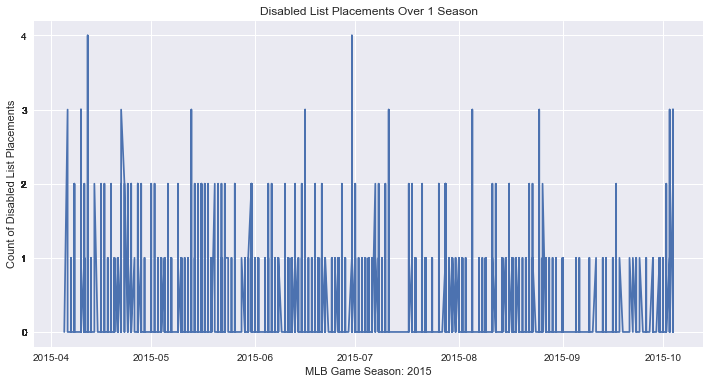

In [84]:
subset = games_w_dummies[(games_add['dt_date']>'2014-12-01')&(games_add['dt_date']<'2015-12-01')]
plt.figure(figsize=(12,6))
plt.plot(subset['dt_date'], subset['injury'])
plt.title('Disabled List Placements Over 1 Season')
plt.yticks(subset['injury'])
plt.xlabel('MLB Game Season: 2015')
plt.ylabel('Count of Disabled List Placements')

In [46]:
# Select columns that I want to map to the player's debut date from player_ids csv:
player_cols = list(games_add.columns[73:95])
player_cols

['w_pitch_id',
 'l_pitch_id',
 'v_start_pitch_id',
 'h_start_pitch_id',
 'v_pl_1_id',
 'v_pl_2_id',
 'v_pl_3_id',
 'v_pl_4_id',
 'v_pl_5_id',
 'v_pl_6_id',
 'v_pl_7_id',
 'v_pl_8_id',
 'v_pl_9_id',
 'h_pl_1_id',
 'h_pl_2_id',
 'h_pl_3_id',
 'h_pl_4_id',
 'h_pl_5_id',
 'h_pl_6_id',
 'h_pl_7_id',
 'h_pl_8_id',
 'h_pl_9_id']

In [56]:
player_ids = pd.read_csv('player_ids.csv')

In [57]:
player_ids.head()

,ID,Last,First,Player_debut
0,aardd001,Aardsma,David,04/06/2004
1,aaroh101,Aaron,Hank,04/13/1954
2,aarot101,Aaron,Tommie,04/10/1962
3,aased001,Aase,Don,07/26/1977
4,abada001,Abad,Andy,09/10/2001


In [58]:
# Create a player_id_dict
player_id_dict = player_ids.loc[:,['Player_debut','ID']]
player_id_dict = player_id_dict.set_index('ID').to_dict()
player_id_dict

{'Player_debut': {'aardd001': '04/06/2004',
  'aaroh101': '04/13/1954',
  'aarot101': '04/10/1962',
  'aased001': '07/26/1977',
  'abada001': '09/10/2001',
  'abadf001': '07/28/2010',
  'abadj101': '04/26/1875',
  'abbae101': '09/04/1897',
  'abbeb101': '06/14/1892',
  'abbec101': '08/16/1893',
  'abbod101': '04/19/1890',
  'abbof101': '04/25/1903',
  'abbog001': '07/29/1973',
  'abboj002': '06/10/1997',
  'abboj001': '04/08/1989',
  'abbok002': '09/07/1993',
  'abbok001': '09/10/1991',
  'abboo101': '09/10/1910',
  'abbop001': '08/21/1990',
  'abbos801': nan,
  'abera101': '09/15/1950',
  'aberd101': '10/21/1871',
  'aberr001': '04/04/2006',
  'aberb101': '09/27/1952',
  'aberb001': '06/25/2001',
  'abert101': '04/13/1955',
  'abert102': '09/19/1942',
  'aberw101': '07/28/1946',
  'aberc101': '07/18/1947',
  'ableh101': '09/04/1905',
  'abnes001': '09/08/1987',
  'abrac101': '04/19/1949',
  'abrag101': '04/19/1923',
  'abrej001': '09/04/1985',
  'abreb001': '09/01/1996',
  'abrej101':

In [ ]:
games_add['date'] = games_add['date'].map(lambda x: str(x)[:4]+ '-' + str(x)[4:6] + '-' + str(x)[6:])
games_add['date'] = pd.to_datetime(games_add['date'])

In [79]:
# Write a function that loops through the player columns and maps the player id to the years 
# that player has been in play:
def years_in_game(date_col, debut_col):
    all_dates = pd.to_datetime(date_col)
    all_debuts = pd.to_datetime(debut_col)
    # make sure the length of the columns is equal and in same format
    range_end = len(date_col)
    new_col_val = []
    if len(date_col) == len(debut_col):
        for i in range(0,range_end):
            days_in_play = all_dates[i] - all_debuts[i]   # subtract debut from game day and assign to list
            new_col_val.append(days_in_play)
    return new_col_val

In [70]:
games_add['date'] = games_add['date'].map(lambda x: str(x)[:4]+ '-' + str(x)[4:6] + '-' + str(x)[6:])
games_add['date'] = pd.to_datetime(games_add['date'])

In [74]:
# For every player column, map the player id to his debut date and turn the debut date into a datetime obj
for col in player_cols:
    games_add[col] = games_add[col].map(player_id_dict['Player_debut'])
    games_add[col] = pd.to_datetime(games_add[col])

In [83]:
for col in player_cols:
    games_add[col] = years_in_game(games_add['date'], games_add[col])

In [85]:
games_add.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41292 entries, 2000-03-29 to 2016-10-02
Data columns (total 97 columns):
real_index              41292 non-null int64
date                    41292 non-null datetime64[ns]
num_game                41292 non-null int64
day                     41292 non-null object
v_team                  41292 non-null object
v_team_game_num         41292 non-null int64
h_team                  41292 non-null object
h_team_game_num         41292 non-null int64
v_team_score            41292 non-null int64
h_team_score            41292 non-null int64
game_length_outs        41292 non-null int64
day_night               41292 non-null object
park_id                 41292 non-null object
attendance              41292 non-null float64
time_game_min           41292 non-null int64
v_at_bats               41292 non-null int64
v_hits                  41292 non-null int64
v_doubles               41292 non-null int64
v_triples               41292 non-null int64
v_h

In [86]:
cols_to_drop = ['real_index','v_mgr_id','h_mgr_id']
cols_to_keep = [item for item in games_add.columns if item not in cols_to_drop]
cols_to_keep

['date',
 'num_game',
 'day',
 'v_team',
 'v_team_game_num',
 'h_team',
 'h_team_game_num',
 'v_team_score',
 'h_team_score',
 'game_length_outs',
 'day_night',
 'park_id',
 'attendance',
 'time_game_min',
 'v_at_bats',
 'v_hits',
 'v_doubles',
 'v_triples',
 'v_homeruns',
 'v_RBI',
 'v_sac_hits',
 'v_sac_files',
 'v_hit_pitch',
 'v_walks',
 'v_int_walks',
 'v_strikeouts',
 'v_stol_base',
 'v_caught_steal',
 'v_grnd_dbl_plays',
 'v_awd_fst_catch_intf',
 'v_left_on_base',
 'v_pitchers',
 'v_ind_earn_runs',
 'v_team_earn_runs',
 'v_wild_pitch',
 'v_balks',
 'v_putouts',
 'v_assists',
 'v_errors',
 'v_pass_balls',
 'v_dbl_plays',
 'v_trp_plays',
 'h_at_bats',
 'h_hits',
 'h_doubles',
 'h_triples',
 'h_homeruns',
 'h_RBI',
 'h_sac_hits',
 'h_sac_files',
 'h_hit_pitch',
 'h_walks',
 'h_int_walks',
 'h_strikeouts',
 'h_stol_base',
 'h_caught_steal',
 'h_grnd_dbl_plays',
 'h_awd_fst_catch_intf',
 'h_left_on_base',
 'h_pitchers',
 'h_ind_earn_runs',
 'h_team_earn_runs',
 'h_wild_pitch',
 'h_ba

In [87]:
# Create a dataframe with just the numerical columns that includes player debut dates
games_with_debuts = games_add.loc[:,cols_to_keep]

In [88]:
# Columns that will be made into dummies: (Make sure to put drop_first=True so one dummy col gets dropped)
col = ['day', 'v_team', 'h_team', 'day_night', 'park_id']
games_w_debuts_dummies = pd.get_dummies(games_with_debuts,columns=col, drop_first=True)

In [89]:
games_w_debuts_dummies.to_csv('games_w_debuts_dummies', index=True)